TASK: find which MACs are the most usefull for location

pip install --upgrade google-cloud-firestore
pip install gcloud

(Esto no parece ayudar)
Download and install Google Cloud SDK    https://cloud.google.com/sdk/docs/quickstart-windows
c:\> gcloud init

Ve a la consola de google y crea una cuenta de servicio
https://cloud.google.com/storage/docs/authentication#generating-a-private-key
    Descarca el json y utilizalo como se muestra a continuación

In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "Puestos-b0665827b03a.json"

In [2]:
from google.cloud import firestore
db = firestore.Client()

In [3]:
import pandas as pd

In [4]:
# Descargar datos de firestore y guardarlos en pandas DataFrame

# Conexion
ann = db.collection(u'ann')
ptos = ann.get()

lista = []
for pto in ptos:
    x = pto.get('pos').longitude
    y = pto.get('pos').latitude
    
    columnas = {'x': x, 'y': y}
    for mac in pto.get('wifi'):
        columnas[mac.get('bssid')] = mac.get('level')
    
    lista.append(columnas)

###
datos = pd.DataFrame(lista)
x_data = datos.drop(labels=['x', 'y'], axis=1)
etiquetas = datos.columns.get_values().tolist()
for a in ['x', 'y']:
    etiquetas.remove(a)
y_data = datos.drop(labels=etiquetas, axis=1)


In [5]:
#Coge solo las que no tienen nulos
print("Nulos en las macs disponibles:")
import operator
sorted(x_data.isnull().sum().items(), key=operator.itemgetter(1))

Nulos en las macs disponibles:


[('24:1f:a0:dc:7f:ff', 0),
 ('44:e4:d9:00:76:40', 0),
 ('44:e4:d9:00:76:41', 0),
 ('44:e4:d9:00:76:42', 0),
 ('44:e4:d9:00:76:43', 0),
 ('44:e4:d9:00:76:44', 0),
 ('58:35:d9:64:58:80', 0),
 ('58:35:d9:64:58:83', 0),
 ('58:35:d9:64:58:84', 0),
 ('58:35:d9:64:58:87', 0),
 ('58:35:d9:64:5b:10', 0),
 ('58:35:d9:64:5b:12', 0),
 ('58:35:d9:64:5b:14', 0),
 ('64:d9:89:99:8d:e0', 0),
 ('44:e4:d9:00:76:47', 1),
 ('58:35:d9:64:5b:11', 1),
 ('88:44:77:13:06:a7', 1),
 ('58:35:d9:64:58:82', 2),
 ('da:c4:6a:ce:1b:34', 2),
 ('f0:ee:10:43:6d:94', 2),
 ('58:35:d9:64:58:81', 3),
 ('58:35:d9:64:5b:17', 3),
 ('64:d9:89:99:8d:e4', 3),
 ('64:d9:89:99:8d:e7', 3),
 ('58:35:d9:64:5b:13', 4),
 ('64:d9:89:99:8d:e1', 4),
 ('64:d9:89:99:8d:e2', 4),
 ('fc:f5:28:c1:1e:e9', 6),
 ('64:d9:89:c4:0d:60', 9),
 ('78:40:e4:93:1d:67', 9),
 ('48:50:73:e3:44:b2', 10),
 ('64:d9:89:99:8d:e3', 11),
 ('c0:62:6b:8e:96:b0', 11),
 ('c0:62:6b:8e:96:b7', 11),
 ('64:d9:89:c4:0d:61', 12),
 ('64:d9:89:c4:0d:62', 12),
 ('64:d9:89:c4:0d:63',

In [6]:
#Usados hasta ahora
macs_old = [
    "24:1f:a0:dc:7f:ff",
    "58:35:d9:64:58:80",
    "58:35:d9:64:58:83",
    "58:35:d9:64:58:82",
    "58:35:d9:64:58:87",
    "64:d9:89:99:8d:e3",
    "44:e4:d9:00:76:41",
    "44:e4:d9:00:76:40",
    "64:d9:89:c4:0d:63",
    "44:e4:d9:00:76:47"]

print("Nulos en las macs usadas hasta ahora:")
for i in macs_old:
    print(x_data[i].isnull().sum())
    
        #--> Probar con los que menos NULL tienen: WI0, WI1, WI2, WI4, WI6, WI7

Nulos en las macs usadas hasta ahora:
0
0
0
2
0
11
0
0
12
1


In [7]:
datos = pd.read_csv('datos.csv')

datos.sample(frac=1)

x_data = datos.drop(labels=['PTO_X', 'PTO_Y'], axis=1)
y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)

macs_old = ['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9']
for i in macs_old:
    count = 0
    for j in x_data[i]:
        if(j == -99):
            count += 1
    print(i, " --> ", count)
    
    #--> Probar con los que menos -99 tienen: WI0, WI1, WI3, WI4, WI5, WI7

WI0  -->  56
WI1  -->  269
WI2  -->  315
WI3  -->  268
WI4  -->  278
WI5  -->  258
WI6  -->  295
WI7  -->  175
WI8  -->  1232
WI9  -->  344


Test: usar la ann anterior pero solo con las entradas que en las ultimas tomas no tienen valores nulos:
        W0, W1, W2, W4, W6, W7

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split #pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

Using TensorFlow backend.


In [9]:
#################################################################################################
#Loading the data
datos = pd.read_csv('datos.csv')

datos.sample(frac=1)

#x_data = datos.drop(labels=['PTO_X', 'PTO_Y', 'WI3', 'WI5', 'WI8', 'WI9'], axis=1)
x_data = datos.drop(labels=['PTO_X', 'PTO_Y', 'WI2', 'WI6', 'WI8', 'WI9'], axis=1)

y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=101)

print("TRAIN DATA: ", x_train.shape)
print("TEST  DATA: ", x_test.shape)

TRAIN DATA:  (1539, 6)
TEST  DATA:  (660, 6)


In [10]:
#################################################################################################
#Normalizing the data
mean = x_train.mean(axis=0).mean()
std  = x_train.std(axis=0).std()
print("MEAN: %f,  STD DEV: %f" % (mean, std))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

MEAN: -62.364089,  STD DEV: 2.511239


In [40]:
#################################################################################################
#ANN Model
batch_size=128
epocas=140000

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(3, activation='relu', input_shape=(x_data.shape[1],), name='cesin'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(2, name='cesout'))
    model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.mse, metrics=[metrics.mae])
    return model
# 7 neuronas capa -> CES ERROR:  9.341623758504909  lr=0.0001
# 4 neuronas capa -> CES ERROR:  9.703250049616706
# 3n 3c lr=.0001 e=13700 -> CES ERROR:  14
# 3n 4c lr=.0001 e=70000 -> CES ERROR:  10.114522437225896
# 3n 5c lr=.0001 e=70000 ->

In [41]:
#################################################################################################
#Train the model  (ep: 22000)
model = build_model()
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epocas, batch_size=batch_size, verbose=0)

KeyboardInterrupt: 

In [42]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)
beep()

Min error 130.436045 at epoch 98970


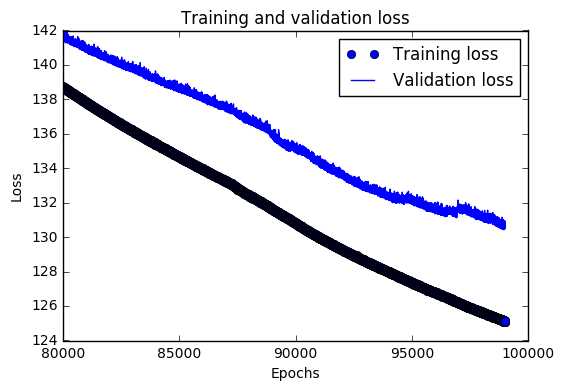

In [39]:
#################################################################################################
#Study the model
print("Min error %f at epoch %d" % (np.min(hist.history['val_loss'][:]), np.argmin(hist.history['val_loss'][:])))

offset0 = 80000
offset1 = None
loss = hist.history['loss'][offset0:offset1]
val_loss = hist.history['val_loss'][offset0:offset1]

epochs = range(offset0 + 1, len(loss) + offset0 + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
test_mae_score

660/660 [==============================] - 0s 71us/step


8.348068832628655

In [31]:
#################################################################################################
#CES error
#
def calcError(real, pred):
    error = 0.
    real0 = np.asarray(real)
    for i in range(real.shape[0]):
        error = error + np.sqrt(pow(pred[i][0] - real0[i][0], 2) + pow(pred[i][1] - real0[i][1], 2))
    return error  /  real.shape[0]

###
y_predicted = model.predict(x_test)

error = calcError(y_test, y_predicted)
print("CES ERROR: ", error)
print("\n")

###
y_test0 = np.asarray(y_test)
for i in range(1,10):
    print("---------------> Real vs Pred.: (%.0f, %.0f) vs (%.0f, %.0f)      err(%.1f, %.1f)"
          % (y_test0[i][0], y_test0[i][1], y_predicted[i][0], y_predicted[i][1],
            y_test0[i][0] - y_predicted[i][0], y_test0[i][1] - y_predicted[i][1]))
print("\n")


#TODO: Maximo error, error medio, desviacion del error...

CES ERROR:  13.283332649371264


---------------> Real vs Pred.: (69, 29) vs (71, 29)      err(-2.1, 0.1)
---------------> Real vs Pred.: (69, 31) vs (72, 39)      err(-2.4, -8.5)
---------------> Real vs Pred.: (77, 87) vs (75, 92)      err(2.4, -5.1)
---------------> Real vs Pred.: (38, 87) vs (74, 77)      err(-35.8, 9.5)
---------------> Real vs Pred.: (85, 77) vs (74, 83)      err(10.9, -6.6)
---------------> Real vs Pred.: (73, 51) vs (72, 35)      err(1.5, 16.2)
---------------> Real vs Pred.: (65, 55) vs (74, 74)      err(-9.3, -19.3)
---------------> Real vs Pred.: (46, 84) vs (74, 77)      err(-27.8, 7.7)
---------------> Real vs Pred.: (78, 68) vs (74, 79)      err(4.1, -10.9)




In [17]:
#model.save("cesnet_redux_last_"+str(error)+".h5")

In [32]:
#################################################################################################
# K Fold Study
k = 3
n_samples = x_data.size // x_data.shape[1] // k

print('Samples by fold: ', n_samples)
all_scores = []
all_hist = []
for i in range(k):
    print('processing fold #', i)

    x_valid3 = x_data[i * n_samples : (i + 1) * n_samples]
    y_valid3 = y_data[i * n_samples : (i + 1) * n_samples]
    x_data3 = np.concatenate([x_data[ : i * n_samples], x_data[(i + 1) * n_samples : ]], axis=0)
    y_data3 = np.concatenate([y_data[ : i * n_samples], y_data[(i + 1) * n_samples : ]], axis=0)

    model3 = build_model()
    hist3 = model3.fit(x_data3, y_data3, validation_data=(x_valid3, y_valid3), epochs=epocas, batch_size=batch_size, verbose=0)
    #all_hist.append(hist3.history['val_loss'])
    y_predicted = model3.predict(x_test)
    all_scores.append(calcError(y_test, y_predicted))
    all_hist.append(hist3.history['val_mean_absolute_error'])
    
    print("Min error %f at epoch %d" % (np.min(hist3.history['val_loss'][:]), np.argmin(hist3.history['val_loss'][:])))
    

Samples by fold:  733
processing fold # 0


KeyboardInterrupt: 

In [33]:
beep()

[]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


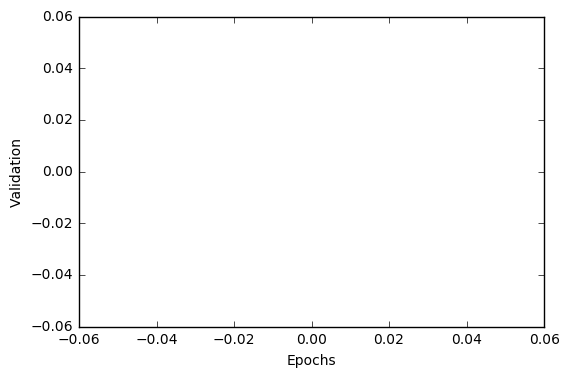

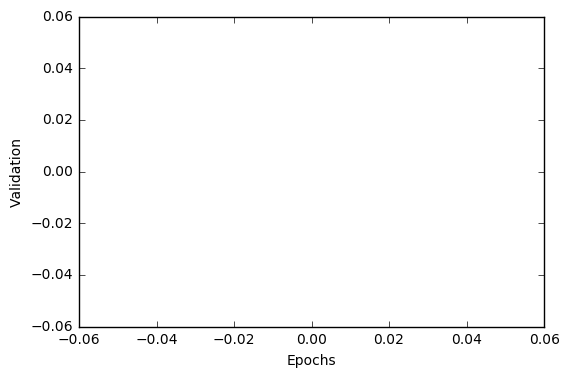

In [34]:
print(all_scores)
average_hist = [np.mean([x[i] for x in all_hist]) for i in range(epocas)]

offset0 = 30000
smooth_history = average_hist[offset0:]
plt.plot(range(1+offset0, len(smooth_history) + 1 + offset0), smooth_history)
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()

offset0 = 25010
smooth_history = average_hist[offset0:]#
plt.plot(range(1+offset0, len(smooth_history) + 1 + offset0), smooth_history)
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()

In [35]:
#Entrenar la red con todos los daton hasta la mejor epoca
epocas_optimas = 60000
x_data2 = (x_data - mean) / std

In [36]:
#
model8 = build_model()
model8.fit(x_data2, y_data, epochs=epocas_optimas, batch_size=batch_size, verbose=0)
test_mse_score, test_mae_score = model8.evaluate(x_test, y_test)
print("test_mse_score=%f, test_mae_score=%f" % (test_mse_score, test_mae_score))
y_predicted = model8.predict(x_test)
error = calcError(y_test, y_predicted)
print("CES ERROR: ", error)
print("\n")


KeyboardInterrupt: 

In [23]:
#model.save("cesnet_redux_last_"+str(error)+".h5")

In [24]:
#>pip install opencv-python
import cv2
cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

ImportError: DLL load failed: No se puede encontrar el módulo especificado.

In [ ]:
#print("x,y,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,m16,m17,m18,m19")

No ejecutar!!

ann = db.collection(u'ann')
ptos = ann.get()

lista_ptos = []
allmacs = {"test1": -99}
i = -1
wifis = []
for pto in ptos:
    x = pto.get('pos').longitude
    y = pto.get('pos').latitude
    #print(y,x)
    lista_ptos.append({'x': x, 'y': y})
    wifis.append({'x': x, 'y': y})
    i += 1
    for mac in pto.get('wifi'):
        dic = {"test0": -99}
        dic[mac.get('bssid')] = mac.get('level')
        wifis[i]['macs'] = dic
        #
        allmacs[mac.get('bssid')] = mac.get('level')

        #print(mac.get('level'),',', mac.get('bssid'))
    #print(u'{} => {}'.format(pto.id, pto.get('fecha')))
    #print(u'{} => {}     {}'.format(pto.get('pos').longitude, pto.get('pos').latitude, pto.to_dict()))
#print(wifis)

lista_macs = []
cabecera = "x,y,"
for mac, level in allmacs.items():
    lista_macs.append(mac)
    cabecera += mac + ","
#print(cabecera)